In [1]:
import firedrake
import matplotlib.pyplot as plt
import icepack.plot
from firedrake import inner, as_vector
import icepack
from firedrake import ds
import numpy as np
import math


firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [2]:
# Read in the mesh used in the Elmer/Ice simulations

sim = 'Flux300Sigma5000' # also run: 'Flux50Sigma5000', 'Flux300Sigma1000', 'Flux300Sigma5000'
mesh = firedrake.Mesh('Mesh/' + sim + '.msh')


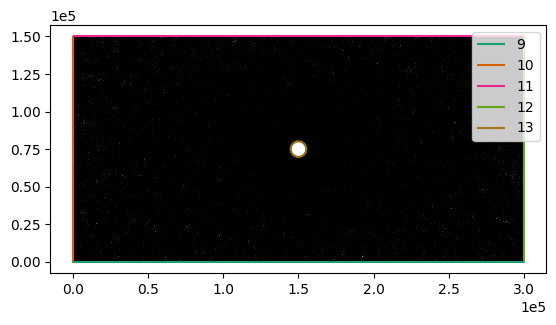

In [3]:
#Plot the mesh

fig, axes = icepack.plot.subplots()
icepack.plot.triplot(mesh, axes=axes)
axes.legend();


In [4]:

x, y = firedrake.SpatialCoordinate(mesh)

In [5]:
# Define the function spaces

Q = firedrake.FunctionSpace(mesh, "CG", 2)
V = firedrake.VectorFunctionSpace(mesh, "CG", 2)

In [6]:
# Define scaling constants

u_scale = 1 #200.0
x_scale = 1 #3000.0
h_scale = 1 #300.0


In [7]:
# Define the inflow boundary velocity and thickness
u_out = 0.0/u_scale #initial guess at what the outflow velocity should be
u_in = 300.0/u_scale #velocity at inflow boundary (kept fixed through simulation)
h_in = 300.0/h_scale #inflow thickness (also kept constant)
Ly = 1.5e5/x_scale

#Define regular shelf flow, but with circular repression around the centre of the ice rise
center = [1.5e5/x_scale, 0.75e5/x_scale]
distance = firedrake.interpolate(firedrake.sqrt((x-center[0])**2 + (y-center[1])**2),Q)
#where distance==min_dist is where the boundary of the domain is
min_dist = distance.dat.data.min()

u_0_x = 0.0
u_0_y = firedrake.min_value(u_in + (u_out - u_in) * (y/Ly), 0.5 * (distance-min_dist))


In [8]:
min_dist

5165.758174561042

In [9]:

h_expr = firedrake.Constant(h_in)
h0 = firedrake.interpolate(h_expr, Q)
u0 = firedrake.interpolate(firedrake.as_vector((u_0_x,u_0_y)), V)


In [10]:
# Define which model we will be using

model = icepack.models.IceShelf()
opts = {
    "dirichlet_ids": [9,13],
    "side_wall_ids": [10,12],
}
solver = icepack.solvers.FlowSolver(model, **opts)


In [11]:
# Set A(T)

#T = firedrake.Constant(255.15)
#A = icepack.rate_factor(T)

yearinsec = 365.25*24*60*60
A = 4.6e-25*yearinsec*1.0e18
A = firedrake.Constant(A)


In [12]:
# Set up the model initially

h = h0.copy(deepcopy=True)
u = solver.diagnostic_solve(
    velocity=u0,
    thickness=h,
    fluidity=A,
)


In [13]:
import tqdm

final_time = 1000
num_timesteps = 1000
dt = final_time / num_timesteps
a = firedrake.Constant(0.0)

for step in tqdm.trange(num_timesteps):
    h = solver.prognostic_solve(
        dt,
        thickness=h, 
        velocity=u,
        accumulation=a,
        thickness_inflow=h0,
    )
    h = firedrake.interpolate(firedrake.max_value(h, 0.001), Q)
    
    u = solver.diagnostic_solve(
        velocity=u,
        thickness=h,
        fluidity=A,
    )

100%|█████████████████████████████████████| 1000/1000 [2:12:41<00:00,  7.96s/it]


In [14]:
from icepack.models.viscosity import membrane_stress
from firedrake import sym, grad, sqrt, tr

S = firedrake.TensorFunctionSpace(mesh, "DG", 1)
ε = firedrake.project(sym(grad(u)), S)

ε_e = firedrake.project(1e3 * sqrt(inner(ε, ε) + tr(ε) ** 2), Q)

degree = 2 * ε.ufl_element().degree()
params = {
    "form_compiler_parameters": {
        "quadrature_degree": degree
    }
}

ε = firedrake.Function(S)
M = firedrake.Function(S)

ε.project(sym(grad(u)))
expr = membrane_stress(strain_rate=ε, fluidity=A)
M.project(expr, **params)


Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x105003460>, TensorElement(FiniteElement('Discontinuous Lagrange', triangle, 1), shape=(2, 2), symmetry={}), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 2)), 6057)

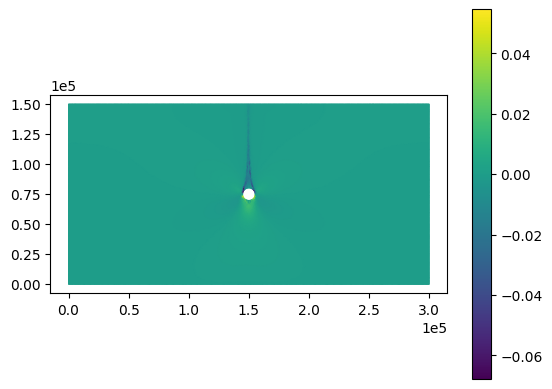

In [15]:
εxx = firedrake.interpolate(ε[0, 0],Q)

fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(εxx, axes=axes)
fig.colorbar(colors);


In [16]:
year = 365.25 * 24 * 60 * 60 # number of seconds in a year
g = 9.81 * year**2 # [m a^{-1}]
rho_i = 900 / year**2 * 1.0e-6 #[MPa m^{-2} a^2]
#sigma_xx = firedrake.interpolate(2 * M[0,0]*h + M[1,1]*h - 0.5 * rho_i * g * h**2, Q)
#sigma_yy = firedrake.interpolate(2 * M[1,1]*h + M[0,0]*h - 0.5 * rho_i * g * h**2, Q)
sigma_xx = firedrake.interpolate(2 * M[0,0]*h + M[1,1]*h - 0.5 * rho_i * g * h**2, Q)
sigma_yy = firedrake.interpolate(2 * M[1,1]*h + M[0,0]*h - 0.5 * rho_i * g * h**2, Q)
sigma_nhp_xx = firedrake.interpolate(2 * M[0,0]*h + M[1,1]*h, Q)
sigma_nhp_yy = firedrake.interpolate(2 * M[1,1]*h + M[0,0]*h, Q)
Mxx = firedrake.interpolate(M[0,0]*h, Q) # 
Myy = firedrake.interpolate(M[1,1]*h, Q) # 
HP = firedrake.interpolate( - 0.5 * rho_i * g * h**2, Q) # negative


In [17]:

#Mxx = firedrake.interpolate(M[0, 0], Q)
#Myy = firedrake.interpolate(M[1, 1], Q)

#outfile = firedrake.File("Simulations/Mxx.pvd")
#outfile.write(Mxx)

#outfile = firedrake.File("Simulations/Myy.pvd")
#outfile.write(Myy)


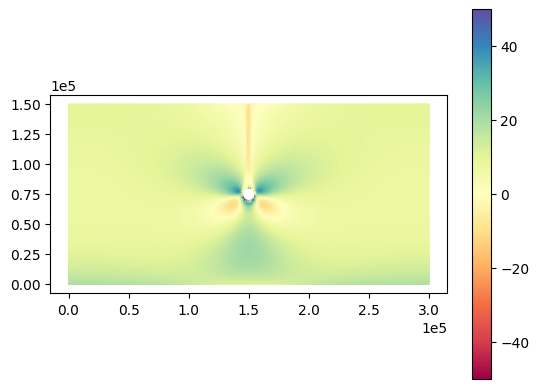

In [18]:
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(Mxx, axes=axes, vmin=-50, vmax=50, cmap="Spectral")
fig.colorbar(colors);

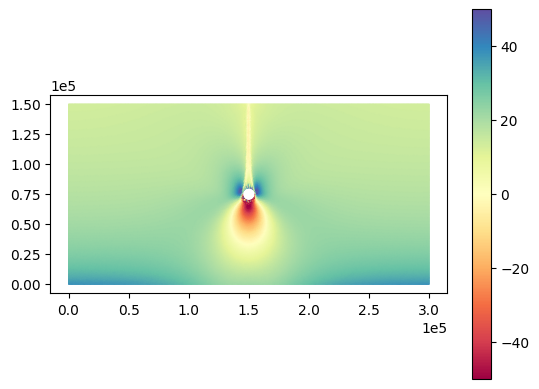

In [19]:
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(Myy, axes=axes, vmin=-50, vmax=50, cmap="Spectral")
fig.colorbar(colors);

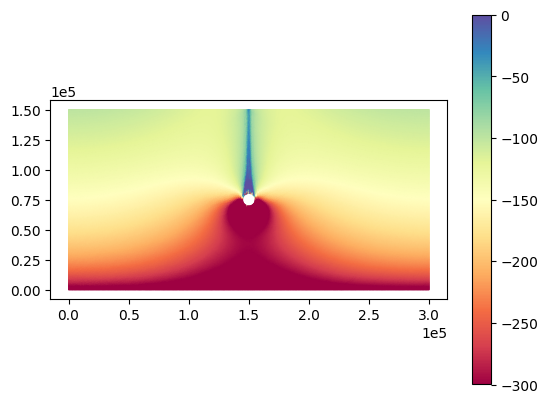

In [20]:
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(sigma_xx, axes=axes, vmin=-300, vmax=0, cmap="Spectral")
fig.colorbar(colors);

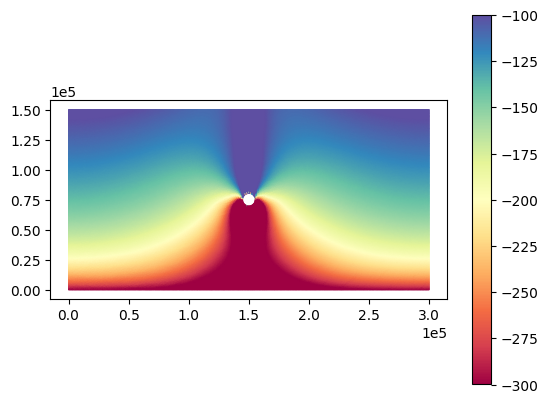

In [21]:
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(sigma_yy, axes=axes, vmin=-300, vmax=-100, cmap="Spectral")
fig.colorbar(colors);

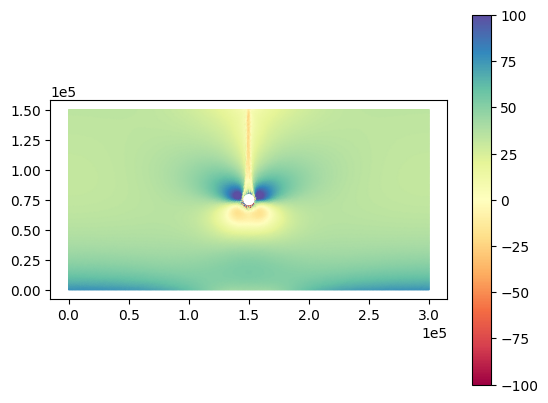

In [22]:
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(sigma_nhp_xx, axes=axes, vmin=-100, vmax=100, cmap="Spectral")
fig.colorbar(colors);

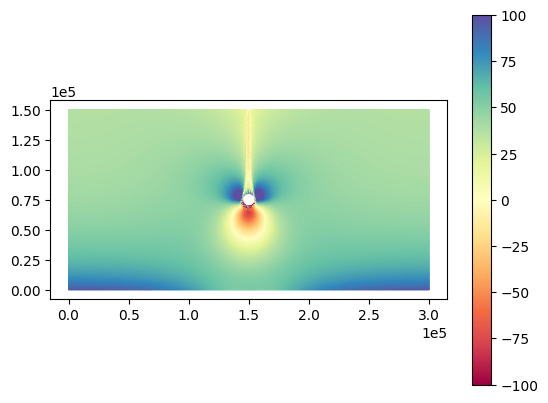

In [23]:
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(sigma_nhp_yy, axes=axes, vmin=-100, vmax=100, cmap="Spectral")
fig.colorbar(colors);

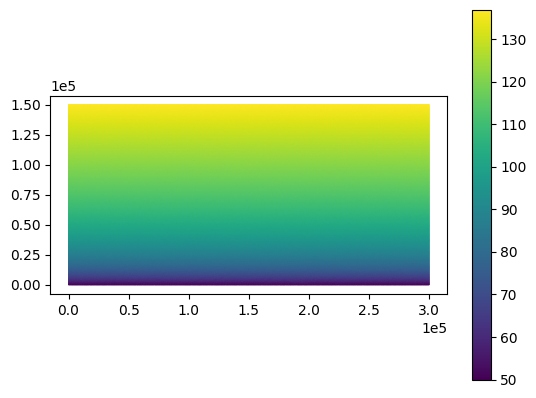

In [38]:
vy = firedrake.interpolate(u[1],Q)

fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(vy, axes=axes)
fig.colorbar(colors);

In [25]:
# Calculate the contribution subtracting the ocean pressure




In [26]:
outfile = firedrake.File('Simulations/sigma_yy_' + sim + '.pvd')
outfile.write(sigma_yy)

In [27]:


outfile = firedrake.File('Simulations/output' + sim + '.pvd')
outfile.write(sigma_yy, h, u, M)